In [ ]:
! pip install kneed

## Load data set

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'food-101' dataset.
Path to dataset files: /kaggle/input/food-101


In [ ]:
path = "/kaggle/input/food-101/food-101/food-101"

## Import Modules

In [ ]:
import os
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from collections import Counter

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    log_loss
)

from kneed import KneeLocator
from scipy.stats import mode

## Data Analysis

In [ ]:
dataset_dir = "/kaggle/input/food-101/food-101/food-101/images"
img_size = (224, 224)
batch_size = 32
seed = 42

classes = os.listdir(dataset_dir)
classes

['macarons',
 'french_toast',
 'lobster_bisque',
 'prime_rib',
 'pork_chop',
 'guacamole',
 'baby_back_ribs',
 'mussels',
 'beef_carpaccio',
 'poutine',
 'hot_and_sour_soup',
 'seaweed_salad',
 'foie_gras',
 'dumplings',
 'peking_duck',
 'takoyaki',
 'bibimbap',
 'falafel',
 'pulled_pork_sandwich',
 'lobster_roll_sandwich',
 'carrot_cake',
 'beet_salad',
 'panna_cotta',
 'donuts',
 'red_velvet_cake',
 'grilled_cheese_sandwich',
 'cannoli',
 'spring_rolls',
 'shrimp_and_grits',
 'clam_chowder',
 'omelette',
 'fried_calamari',
 'caprese_salad',
 'oysters',
 'scallops',
 'ramen',
 'grilled_salmon',
 'croque_madame',
 'filet_mignon',
 'hamburger',
 'spaghetti_carbonara',
 'miso_soup',
 'bread_pudding',
 'lasagna',
 'crab_cakes',
 'cheesecake',
 'spaghetti_bolognese',
 'cup_cakes',
 'creme_brulee',
 'waffles',
 'fish_and_chips',
 'paella',
 'macaroni_and_cheese',
 'chocolate_mousse',
 'ravioli',
 'chicken_curry',
 'caesar_salad',
 'nachos',
 'tiramisu',
 'frozen_yogurt',
 'ice_cream',
 'ris

In [ ]:
selected_classes = [
    "pizza",
    "hamburger",
    "fried_rice",
    "macarons",
    "spaghetti_carbonara"
]

In [ ]:
image_counts = {}
for cls in selected_classes:
    cls_dir = os.path.join(dataset_dir, cls)
    image_counts[cls] = len(os.listdir(cls_dir))

print(image_counts)

{'pizza': 1000, 'hamburger': 1000, 'fried_rice': 1000, 'macarons': 1000, 'spaghetti_carbonara': 1000}


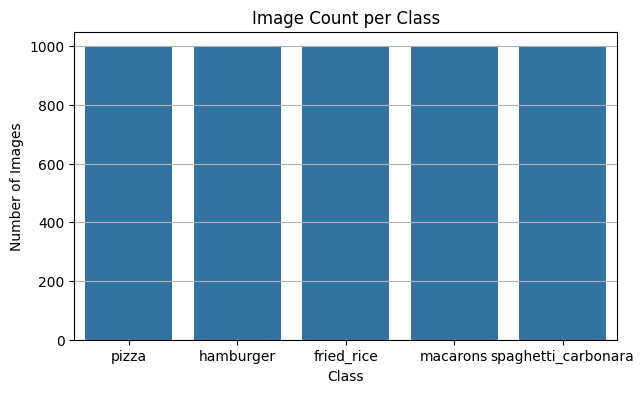

In [ ]:
plt.figure(figsize=(7, 4))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title("Image Count per Class")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.grid(axis="y")
plt.show()

In [ ]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    class_names=selected_classes,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

class_names = full_ds.class_names
num_classes = len(class_names)

Found 5000 files belonging to 5 classes.


In [ ]:
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)

train_ds = full_ds.take(train_size)
rest_ds  = full_ds.skip(train_size)

val_ds   = rest_ds.take(val_size)
test_ds  = rest_ds.skip(val_size)

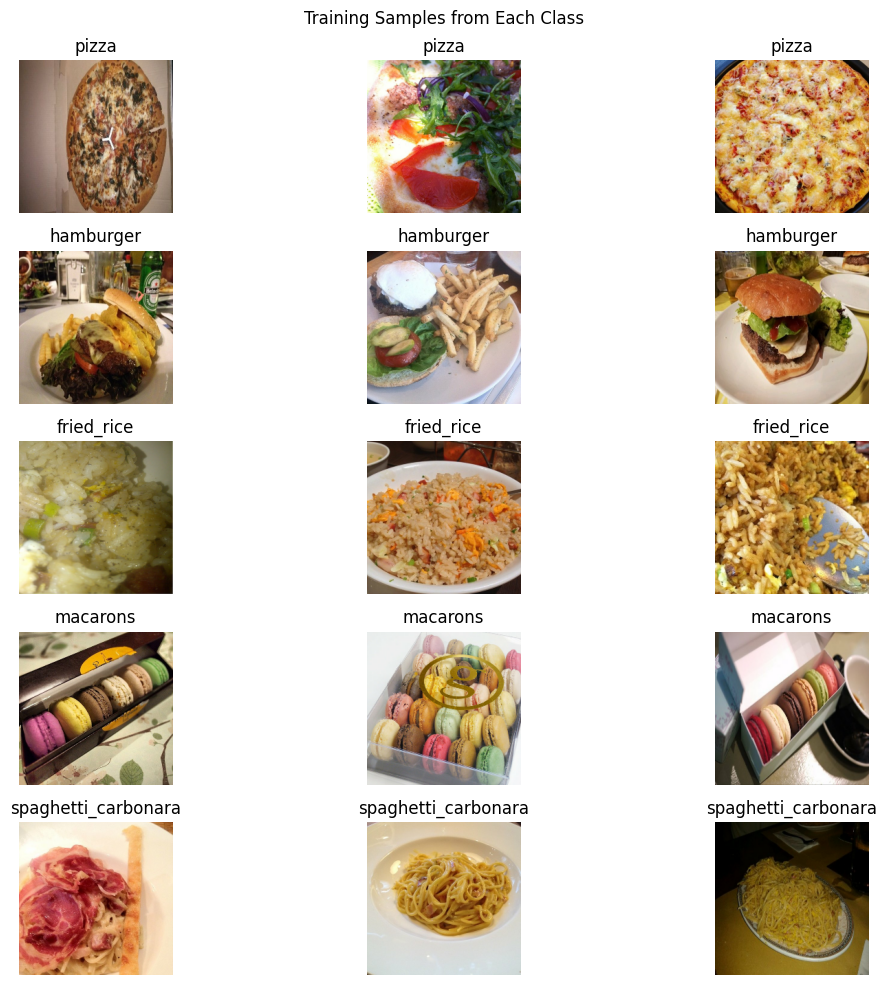

In [ ]:
plt.figure(figsize=(12, 10))
shown = {cls: 0 for cls in class_names}

for images, labels in train_ds:
    for img, label in zip(images, labels):
        cls = class_names[label]
        if shown[cls] < 3:
            idx = class_names.index(cls) * 3 + shown[cls] + 1
            plt.subplot(num_classes, 3, idx)
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(cls)
            plt.axis("off")
            shown[cls] += 1
    if all(v == 3 for v in shown.values()):
        break

plt.suptitle("Training Samples from Each Class")
plt.tight_layout()
plt.show()

In [ ]:
def compute_brightness_contrast(images):
    brightness = []
    contrast = []

    for img in images:
        img_arr = img.numpy().astype(np.float32)
        if img_arr.ndim == 3:
            img_gray = img_arr.mean(axis=2)
        else:
            img_gray = img_arr

        brightness.append(img_gray.mean())
        contrast.append(img_gray.std())

    return np.array(brightness), np.array(contrast)

In [ ]:
all_images = []
for imgs, labels in train_ds:
    all_images.extend(imgs)

brightness, contrast = compute_brightness_contrast(all_images)

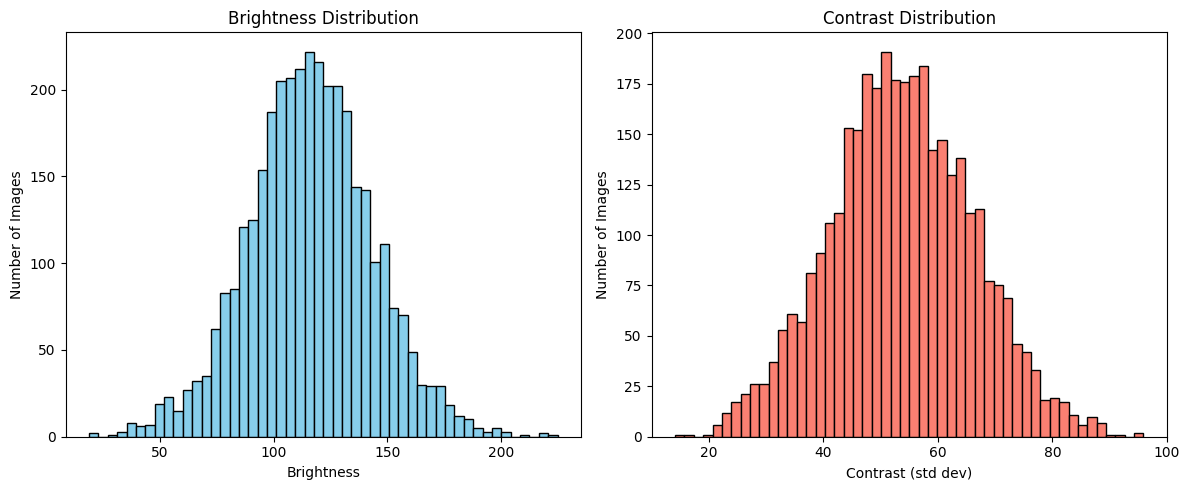

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(brightness, bins=50, color='skyblue', edgecolor='black')
plt.title("Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Number of Images")

plt.subplot(1,2,2)
plt.hist(contrast, bins=50, color='salmon', edgecolor='black')
plt.title("Contrast Distribution")
plt.xlabel("Contrast (std dev)")
plt.ylabel("Number of Images")

plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
def preprocess(img, label):
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, label

In [ ]:
train_ds = train_ds.map(preprocess)
val_ds   = val_ds.map(preprocess)
test_ds  = test_ds.map(preprocess)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3),
    pooling="avg"
)
base_model.trainable = False

## Feature Extraction

In [ ]:
def extract_features(ds):
    X, y = [], []
    for imgs, labels in ds:
        feats = base_model(imgs, training=False).numpy()
        X.append(feats)
        y.append(labels.numpy())
    return np.vstack(X), np.hstack(y)

In [ ]:
X_train, y_train = extract_features(train_ds)
X_val,   y_val   = extract_features(val_ds)
X_test,  y_test  = extract_features(test_ds)

## Normalization

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

## Logistic Regression

In [ ]:
clf = LogisticRegression(
    max_iter=2000,
    C=10,
    solver="saga",
    multi_class="multinomial"
)
clf.fit(X_train_s, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, max_iter=2000, multi_class='multinomial',
                   solver='saga')

In [ ]:
train_pred = clf.predict(X_train_s)
train_accuracy = accuracy_score(y_train, train_pred)

print(f"Train Accuracy: {train_accuracy*100:.2f}%")

y_pred = clf.predict(X_test_s)
y_prob = clf.predict_proba(X_test_s)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy: 96.91%


In [ ]:
print("\nClassification Report (TEST):\n")
print(classification_report(y_test, y_pred, target_names=class_names))


Classification Report (TEST):

                     precision    recall  f1-score   support

              pizza       0.98      0.98      0.98       152
          hamburger       0.95      0.98      0.97       146
         fried_rice       0.95      0.95      0.95       164
           macarons       0.99      0.98      0.98       163
spaghetti_carbonara       0.97      0.96      0.97       151

           accuracy                           0.97       776
          macro avg       0.97      0.97      0.97       776
       weighted avg       0.97      0.97      0.97       776



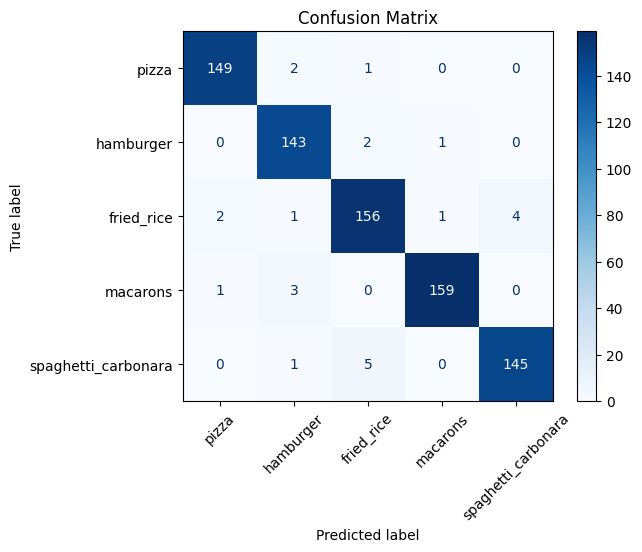

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

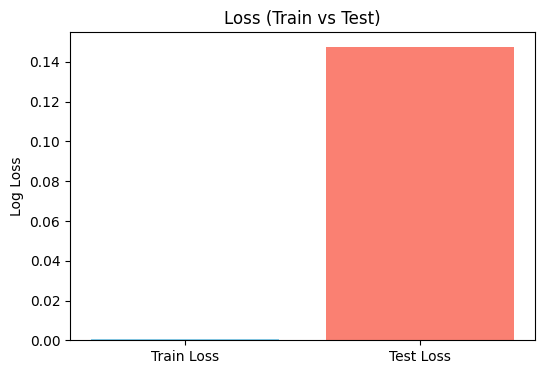

In [ ]:
y_prob_train = clf.predict_proba(X_train_s)
y_prob_test = clf.predict_proba(X_test_s)

train_loss = log_loss(y_train, y_prob_train)
test_loss  = log_loss(y_test, y_prob_test)

plt.figure(figsize=(6,4))
plt.bar(['Train Loss', 'Test Loss'], [train_loss, test_loss], color=['skyblue','salmon'])
plt.ylabel("Log Loss")
plt.title("Loss (Train vs Test)")
plt.show()

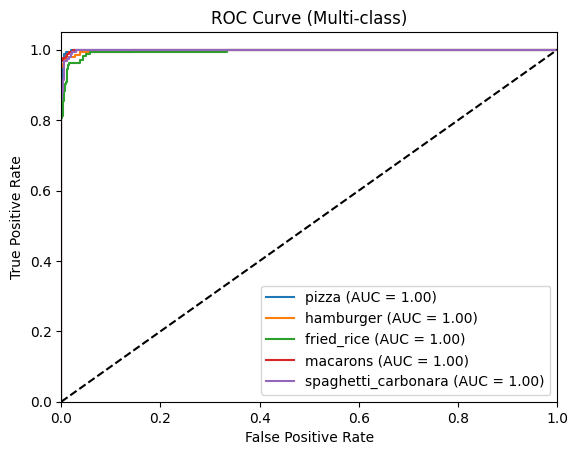

In [ ]:
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
joblib.dump(clf, "logistic_model.pkl")

joblib.dump(scaler, "scaler.pkl")

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Model, scaler, and class names saved successfully!")

Model, scaler, and class names saved successfully!


## K Means

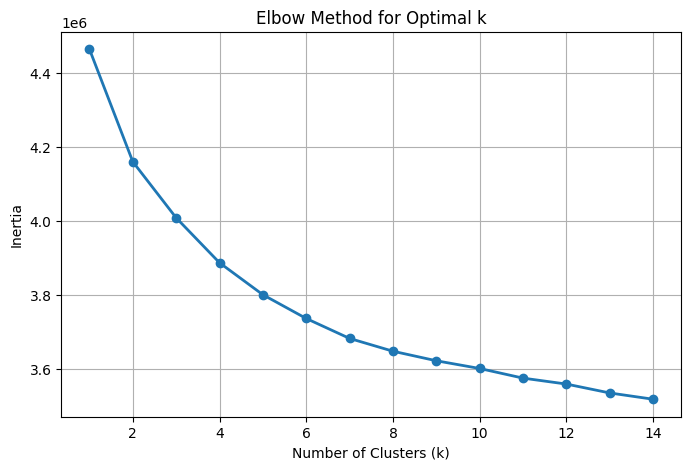

In [ ]:
inertia = []
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_s)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', linewidth=2)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [ ]:
kneedle = KneeLocator(
    K,
    inertia,
    curve="convex",
    direction="decreasing"
)

optimal_k = kneedle.knee
print("Best k from Elbow Method =", optimal_k)

Best k from Elbow Method = 5


In [ ]:
k = optimal_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_train_s)

KMeans(n_clusters=np.int64(5), n_init=10, random_state=42)

In [ ]:
def map_clusters_to_labels(y_true, y_clusters):
    labels = np.zeros_like(y_clusters)
    for i in range(k):
        mask = (y_clusters == i)
        if np.sum(mask) == 0:
            continue
        labels[mask] = mode(y_true[mask])[0]
    return labels

In [ ]:
train_clusters = kmeans.labels_
train_pred = map_clusters_to_labels(y_train, train_clusters)

test_clusters = kmeans.predict(X_test_s)
y_pred_test = map_clusters_to_labels(y_test, test_clusters)

In [ ]:
train_acc = accuracy_score(y_train, train_pred)
test_acc  = accuracy_score(y_test, y_pred_test)
print(f"K-Means Train Accuracy: {train_acc*100:.2f}%")
print(f"K-Means Test Accuracy: {test_acc*100:.2f}%")

K-Means Train Accuracy: 92.09%
K-Means Test Accuracy: 93.43%


In [ ]:
print("\nClassification Report (Test):\n")
print(classification_report(y_test, y_pred_test, target_names=class_names))


Classification Report (Test):

                     precision    recall  f1-score   support

              pizza       0.99      0.95      0.97       152
          hamburger       0.89      0.97      0.93       146
         fried_rice       0.92      0.93      0.92       164
           macarons       0.90      0.93      0.92       163
spaghetti_carbonara       0.99      0.90      0.94       151

           accuracy                           0.93       776
          macro avg       0.94      0.93      0.94       776
       weighted avg       0.94      0.93      0.93       776



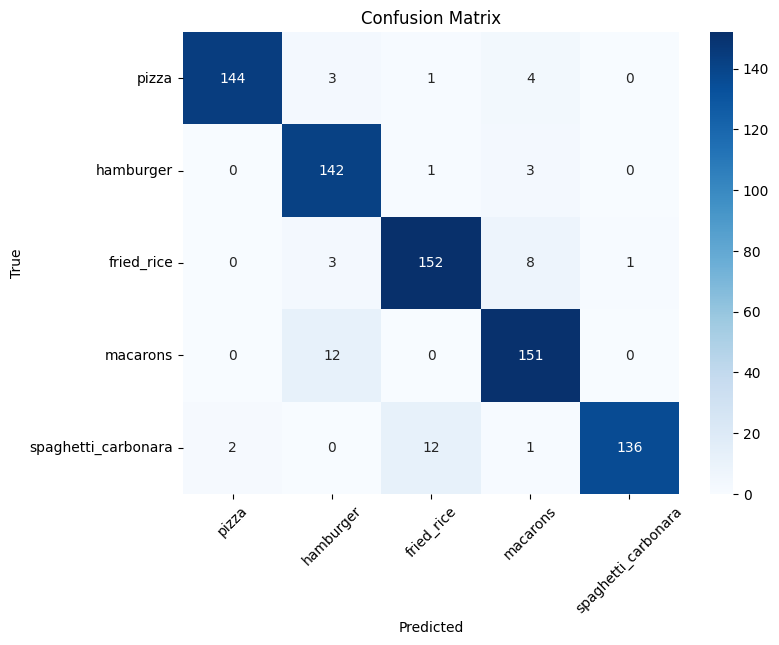

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

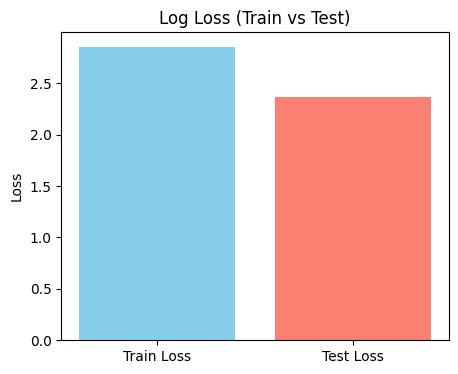

In [ ]:
y_prob_train = label_binarize(train_pred, classes=range(k))
y_prob_test = label_binarize(y_pred_test, classes=range(k))
train_loss = log_loss(label_binarize(y_train, classes=range(k)), y_prob_train)
test_loss  = log_loss(label_binarize(y_test, classes=range(k)), y_prob_test)

plt.figure(figsize=(5,4))
plt.bar(['Train Loss','Test Loss'], [train_loss, test_loss], color=['skyblue','salmon'])
plt.title("Log Loss (Train vs Test)")
plt.ylabel("Loss")
plt.show()

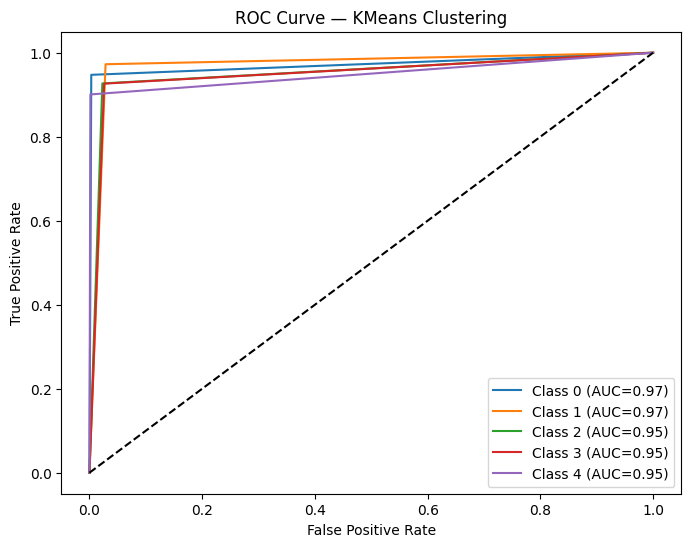

In [ ]:
n_clusters = k

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred_test, classes=np.unique(y_pred_test))

plt.figure(figsize=(8,6))

for i in range(y_test_bin.shape[1]):
    if y_test_bin[:,i].sum() == 0:
        continue

    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_pred_bin[:,i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — KMeans Clustering")
plt.legend()
plt.show()

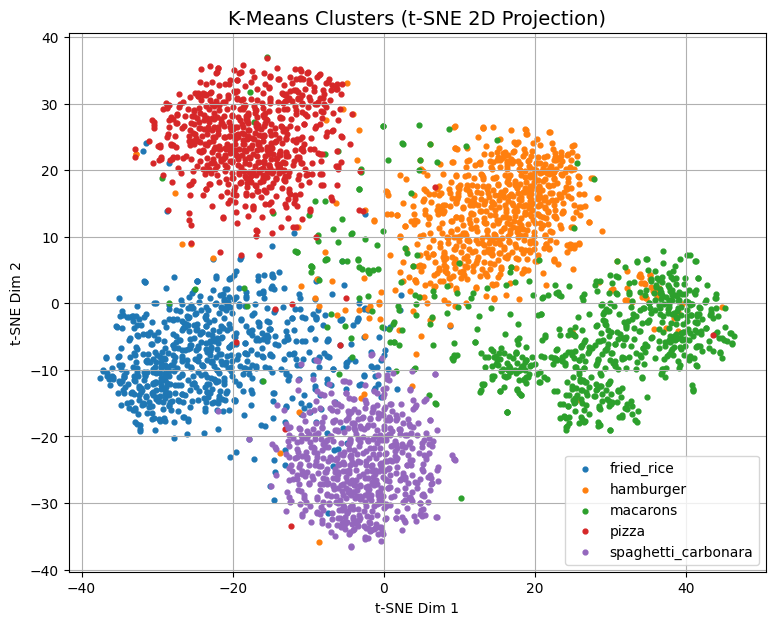

In [ ]:
cluster_labels_numeric = map_clusters_to_labels(y_train, train_clusters)

cluster_labels_names = [class_names[i] for i in cluster_labels_numeric]

import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_s)

plt.figure(figsize=(9,7))
for cls in np.unique(cluster_labels_names):
    mask = np.array(cluster_labels_names) == cls
    plt.scatter(X_train_tsne[mask,0], X_train_tsne[mask,1], label=cls, s=12)

plt.title("K-Means Clusters (t-SNE 2D Projection)", fontsize=14)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(scaler, "scaler.pkl")
import json
with open("class_names.json","w") as f:
    json.dump(class_names, f)

print("KMeans model, scaler, and class names saved successfully!")

KMeans model, scaler, and class names saved successfully!
